# Project Fitness Gym: churn prediction

The gym chain Model Fitness is developing a customer interaction strategy based on analytical data.

In order to fight churn, Model Fitness has digitized a number of its customer profiles. The task of this project is to analyze them and come up with a customer retention strategy.

The project includes:
- Preprocessing and exploration of data
- Building and evaluating model to predict the probability of churn (for the upcoming month) for each customer
- Analysis of the factors that impact churn most
- Drawing up typical user portrait
- Drawing basic conclusions and develop recommendations on how to improve customer service

## Downloading and preprocessing

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from scipy.cluster.hierarchy import dendrogram, linkage 
from sklearn.cluster import KMeans

In [2]:
try:
    data=pd.read_csv('/datasets/gym_churn_us.csv')
except:
    data=pd.read_csv('gym_churn_us.csv')

In [3]:
data.head()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


- Churn' — the fact of churn for the month in question

Current dataset fields:
User data for the preceding month
- 'gender'
- 'Near_Location' — whether the user lives or works in the neighborhood where the gym is located
- 'Partner' — whether the user is an employee of a partner company (the gym has partner companies whose employees get discounts; in those cases the gym stores information on customers' employers)
- Promo_friends — whether the user originally signed up through a "bring a friend" offer (they used a friend's promo code when paying for their first membership)
- 'Phone' — whether the user provided their phone number
- 'Age'
- 'Lifetime' — the time (in months) since the customer first came to the gym

Data from the log of visits and purchases and data on current membership status
- 'Contract_period' — 1 month, 3 months, 6 months, or 1 year
- 'Month_to_end_contract' — the months remaining until the contract expires
- 'Group_visits' — whether the user takes part in group sessions
- 'Avg_class_frequency_total' — average frequency of visits per week over the customer's lifetime
- 'Avg_class_frequency_current_month' — average frequency of visits per week over the preceding month
- 'Avg_additional_charges_total' — the total amount of money spent on other gym services: cafe, athletic goods, cosmetics, massages, etc.

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

'Contract_period' is a categorical field by it's nature, so I will convert it into binary columns:

In [5]:
data['Contract'] = (data['Contract_period'].map({1: '1m', 6: '6m', 12:'12m'}))
data = data.drop(['Contract_period'], axis =1)

In [6]:
data = pd.get_dummies(data)

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 16 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Group_visits                       4000 non-null   int64  
 6   Age                                4000 non-null   int64  
 7   Avg_additional_charges_total       4000 non-null   float64
 8   Month_to_end_contract              4000 non-null   float64
 9   Lifetime                           4000 non-null   int64  
 10  Avg_class_frequency_total          4000 non-null   float64
 11  Avg_class_frequency_current_month  4000 non-null   float

## Exploratory data analysis

In [8]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
gender,4000.0,0.510250,0.499957,0.000000,0.000000,1.000000,1.000000,1.000000
Near_Location,4000.0,0.845250,0.361711,0.000000,1.000000,1.000000,1.000000,1.000000
Partner,4000.0,0.486750,0.499887,0.000000,0.000000,0.000000,1.000000,1.000000
Promo_friends,4000.0,0.308500,0.461932,0.000000,0.000000,0.000000,1.000000,1.000000
Phone,4000.0,0.903500,0.295313,0.000000,1.000000,1.000000,1.000000,1.000000
Group_visits,4000.0,0.412250,0.492301,0.000000,0.000000,0.000000,1.000000,1.000000
Age,4000.0,29.184250,3.258367,18.000000,27.000000,29.000000,31.000000,41.000000
Avg_additional_charges_total,4000.0,146.943728,96.355602,0.148205,68.868830,136.220159,210.949625,552.590740
Month_to_end_contract,4000.0,4.322750,4.191297,1.000000,1.000000,1.000000,6.000000,12.000000
Lifetime,4000.0,3.724750,3.749267,0.000000,1.000000,3.000000,5.000000,31.000000


**Summary information on clients:**
- 84% of clients live near the gym
- 49% of them are employees of partner company
- 31% originally signed up through a "bring a friend" offer
- 41% participate in group sessions
- 55% of clients has 1 month contracts
- Average indicators:
    - The average age of client is 29 years
    - The average of the total amount of money spent on other gym services (cafe, athletic goods, cosmetics, massages and etc.) is 145 currency units
    - On average the client first came to the gym about 4 months ago (3.7)
    - The average frequency of visits per week (over the customer's lifetime) is almost 2 (1.9)
    - The average churn rate is 26%.

In [9]:
data.groupby('Churn').mean().T

Churn,0,1
gender,0.510037,0.510839
Near_Location,0.873086,0.768143
Partner,0.534195,0.355325
Promo_friends,0.353522,0.183789
Phone,0.903709,0.902922
Group_visits,0.464103,0.268615
Age,29.976523,26.989632
Avg_additional_charges_total,158.445715,115.082899
Month_to_end_contract,5.283089,1.662582
Lifetime,4.711807,0.990575


'Gender' and 'Phone' features does not vary significantly for staying and leaving clients, therefore I exclude them from features charts plotting in the next sections.

### Categorical values plots

I will use pie plots for categorical values.

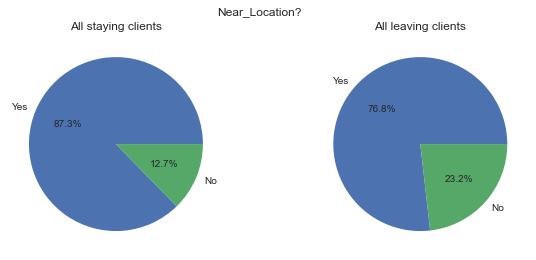

___________________________________________________________________


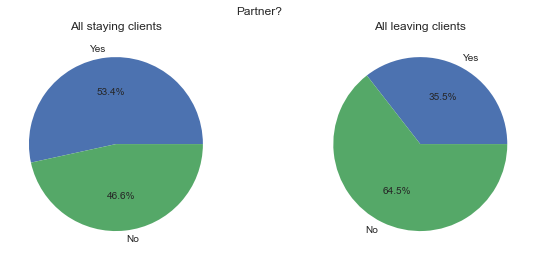

___________________________________________________________________


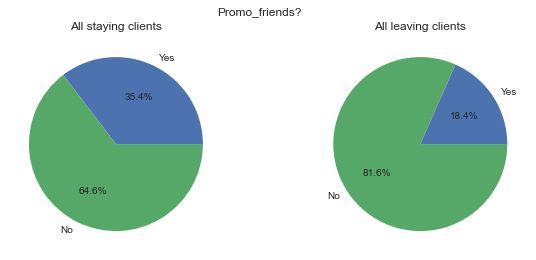

___________________________________________________________________


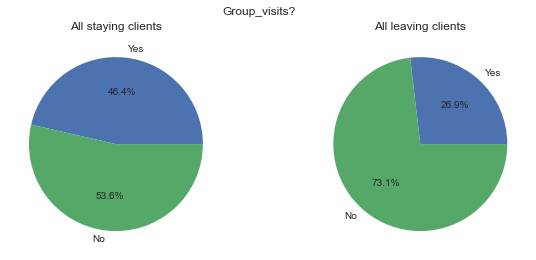

___________________________________________________________________


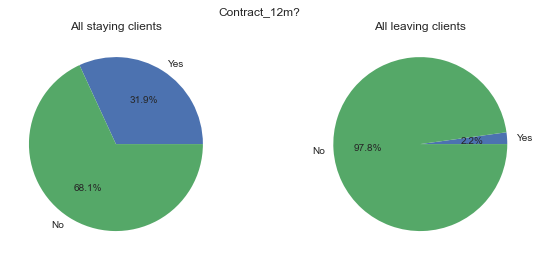

___________________________________________________________________


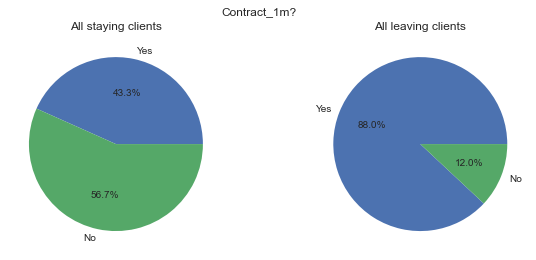

___________________________________________________________________


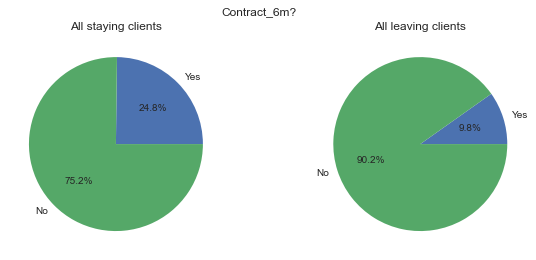

___________________________________________________________________


In [10]:
for col in data[['Near_Location', 'Partner', 'Promo_friends', 'Group_visits',
                 'Contract_12m', 'Contract_1m', 'Contract_6m']]:
    plt.style.use('seaborn')
    fig1, axs = plt.subplots(1, 2, figsize=(10,4))
    fig1.suptitle(col +'?')
    axs[0].pie([data.query('Churn == 0')[col].mean(),
         1-data.query('Churn == 0')[col].mean()],           
        labels = ['Yes', 'No'], autopct='%1.1f%%')
    axs[0].set_title('All staying clients')
    axs[1].pie([data.query('Churn == 1')[col].mean(),
         1-data.query('Churn == 1')[col].mean()],
        labels = ['Yes', 'No'], autopct='%1.1f%%')
    axs[1].set_title('All leaving clients')
    plt.show()
    print('___________________________________________________________________')

**Overview of leaving and staying clients categorical data:**
- Clients, who live near a gym are less likely to leave: 87% of those who remained lived near a gym (compared to 77% of clients who left)
- Employees of partner companies are less likely to churn: 53% of those who remained were employees of partner companies (compared to 36% of clients who left)
- Clients signed up through a "bring a friend" offer are less likely to churn: 35% of those who remained used this offer (compared to 18% of clients who left)
- Clients taking part in group sessions are less likely to churn: 46% of those who remained visit group sessions (compared to 27% of clients who left)
- Clients with contract period of 1 month leave more often (88% of clients with 1 month contract have left), than clients with contracts for 6 or 12 months.

### Numerical values plots

For numerical values I will use histograms.

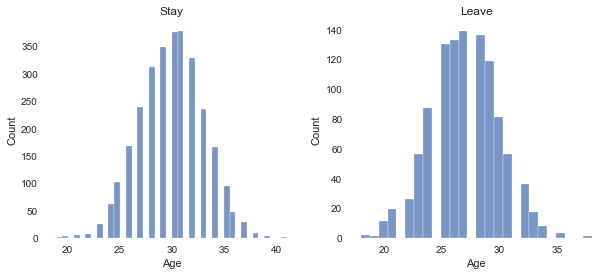

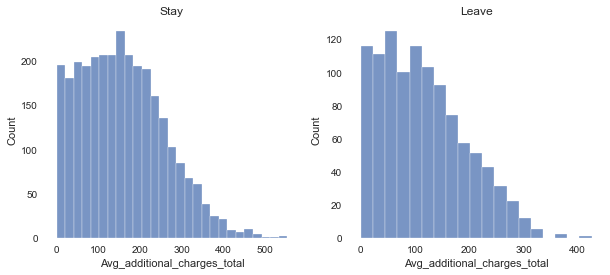

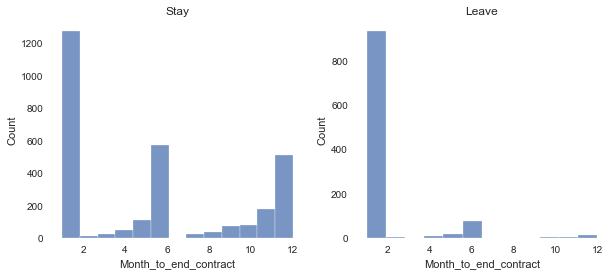

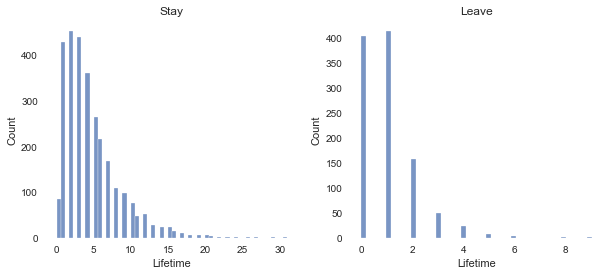

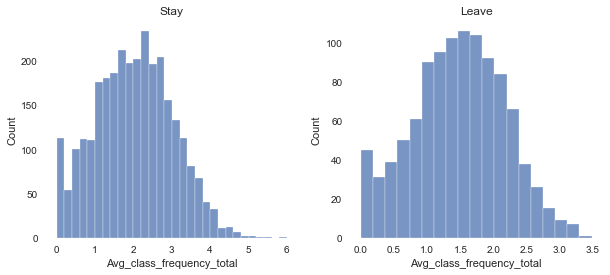

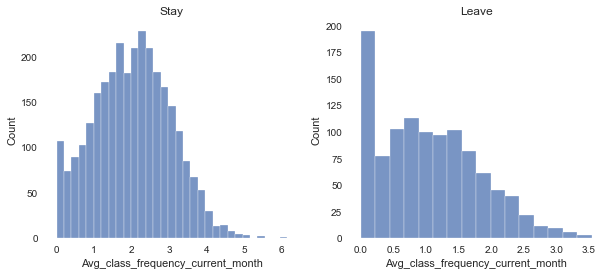

In [11]:
for col in data[['Age', 'Avg_additional_charges_total', 'Month_to_end_contract','Lifetime',
                'Avg_class_frequency_total', 'Avg_class_frequency_current_month']]:
    sns.set_style("white")
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    sns.histplot(data=data.query('Churn == 0'), x=col, ax=axes[0]).set(title='Stay')
    sns.histplot(data=data.query('Churn == 1'), x=col, ax=axes[1]).set(title='Leave')
    plt.show()

**Overview of leaving and staying clients numerical data:**
- Staying clients are a bit older - average age is 30 years (vs. 27 years average age of leaving clients)
- Staying clients spend more money on other services: the average of the total amount is 158 currency units for staying clients and 115 for leaving clients.
- Clients are more likely to churn when the contract expires soon (leaving clients had on average 1.7 month to end of contract)
- Leaving clients have very short lifetime in gym - 1 month  on average (compared to 5.2 months for those who stayed) 
- Leaving clients tend to visit gym less frequently: 1.5 times per week over the lifetime and 1 time for week in the last month on average (compared to stable 2 times per week for staying clients). 
- No visits during last month increases the probability of churn.

### Heatmap

In [12]:
corr=data.corr()

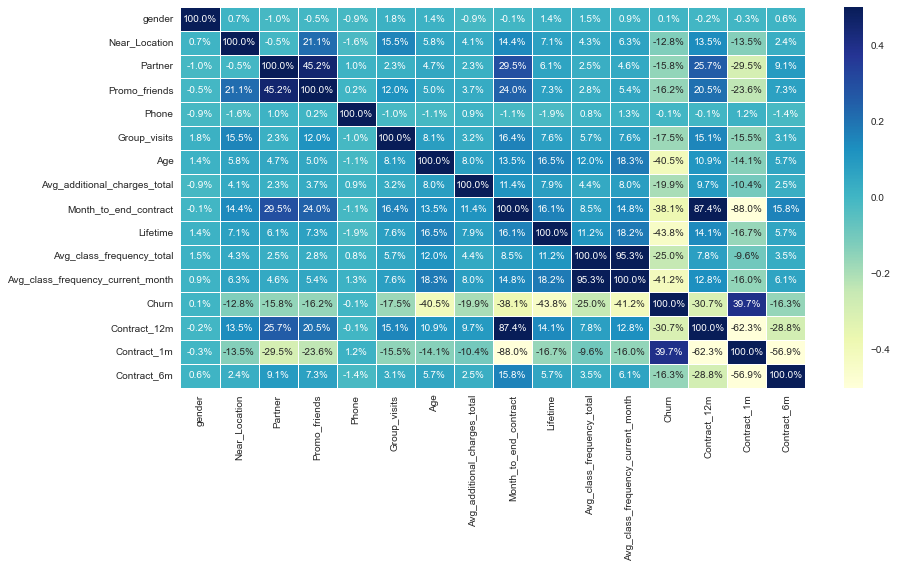

In [13]:
plt.figure(figsize=(14,7))
sns.heatmap(corr, annot=True, fmt='.1%', cmap="YlGnBu", linewidths=1, linecolor='white', vmin=-0.5, vmax=0.5)
plt.show()

Several features has strongly correlation with each other. Since mutual correlation is undesirable with linear models I will remove these features from data for Logistic regression model:

In [14]:
data_log=data.drop(['Contract_12m', 'Contract_1m', 'Avg_class_frequency_total'], axis = 1)

## Building a model to predict user churn

Here I will build a binary classification model for customers where the target feature is the user's leaving next month. I will use 2 methods:
- logistic regression
- random forest

### Logistic regression model

In [15]:
# divide the data into features (the X matrix) and a target variable (y)
X = data_log.drop(['Churn'], axis=1) 
y = data_log['Churn'] 

In [16]:
# divide the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [17]:
# create a StandardScaler object and apply it to the train set
scaler = StandardScaler() # write your code here
X_train_st = scaler.fit_transform(X_train) # train the scaler and transform the matrix for the train set

# apply standardization to the feature matrix for the test set
X_test_st = scaler.transform(X_test)

In [18]:
model = LogisticRegression(random_state=0) # defining the model's algorithm 
model.fit(X_train_st, y_train) # training model
predictions = model.predict(X_test_st) # binary prediction

In [19]:
# calculating metrics for the resulting prediction
as1=accuracy_score(y_test, predictions)
ps1=precision_score(y_test, predictions)
rs1=recall_score(y_test, predictions)

# creating table to display metrics
model_df=pd.DataFrame({'log_regression': [as1, ps1, rs1]})
index = pd.Index(['Accuracy','Precision','Recall'])
model_df=model_df.set_index(index)

### Random forest model

In [20]:
X = data.drop(['Churn'], axis=1) 
y = data['Churn'] 

In [21]:
# divide the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [22]:
# create a StandardScaler object and apply it to the train set
scaler = StandardScaler() # write your code here
X_train_st = scaler.fit_transform(X_train) # train the scaler and transform the matrix for the train set

# apply standardization to the feature matrix for the test set
X_test_st = scaler.transform(X_test)

In [23]:
model2 = RandomForestClassifier(n_estimators=100, random_state=0) # defining the model's algorithm 
model2.fit(X_train_st, y_train) # training model
predictions2 = model2.predict(X_test_st) # binary prediction

In [24]:
# calculating metrics for the resulting prediction
as2=accuracy_score(y_test, predictions2)
ps2=precision_score(y_test, predictions2)
rs2=recall_score(y_test, predictions2)

#adding column to table with metrics
model_df['random_forest']=[as2, ps2, rs2]

### Models evaluation

In [25]:
# fuction to compare metrics
def result(row):
    if row['log_regression'] > row['random_forest']: 
        return 'log_regression'
    else:
        return 'random_forest'

In [26]:
model_df['winner']=model_df.apply(result, axis=1)
model_df

,log_regression,random_forest,winner
Accuracy,0.907500,0.912500,random_forest
Precision,0.806931,0.844086,random_forest
Recall,0.823232,0.792929,log_regression


- Accuracy only works when classes are balanced, i.e. when objects are distributed almost evenly between the classes, which is not the case here, so we need to use other metrics.

- Precision tells us what share of predictions in class 1 are true. In other words, we look at the share of correct answers only in the target class. 
- Recall demonstrates the number of real class 1 objects we are able to discover with our model. This metric is useful in diagnosing diseases. In our case Recall is more important, since we need to identify leaving clients.

Logistic Regression demonstrates better score on Recall, so I would recommend to use this model.

## Creating user clusters

### Dendrogram

In [27]:
#standardizing the data
sc = StandardScaler()
x_sc = sc.fit_transform(data.drop(['Churn'], axis=1))

In [28]:
linked = linkage(x_sc, method = 'ward') 

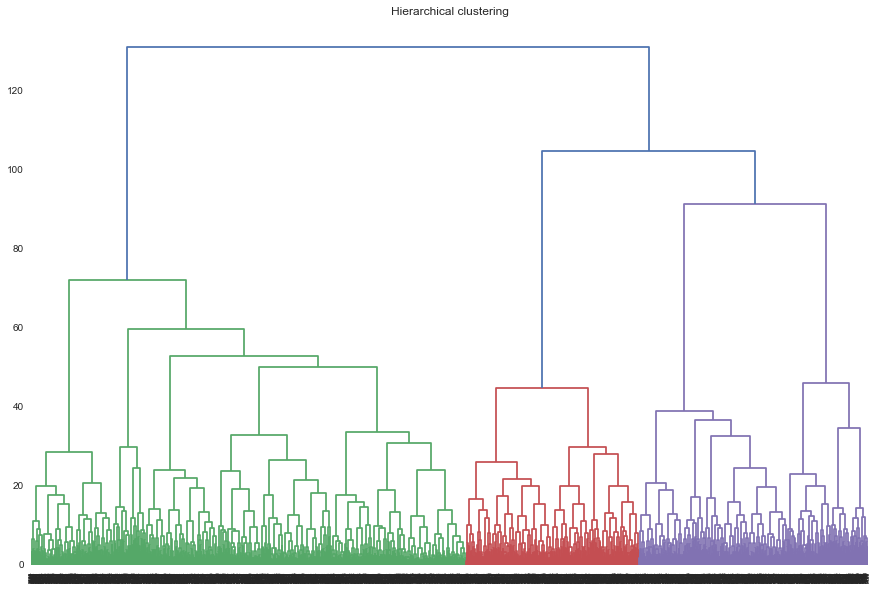

In [29]:
#plotting a dendrogram
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Hierarchical clustering')
plt.show() 

I will train the clustering model with the K-means algorithm and predict customer clusters (using n=5). 

### K-means clustering model

In [30]:
km = KMeans(n_clusters = 5, random_state=0)

In [31]:
labels = km.fit_predict(x_sc)

In [32]:
data['Cluster'] = labels

### Categorical values plots for clusters

Calculating mean feature values for clusters:

In [33]:
mean_clusters=data.groupby('Cluster').mean().reset_index()
mean_clusters.T

,0,1,2,3,4
Cluster,0.000000,1.000000,2.000000,3.000000,4.000000
gender,0.513889,0.551129,0.516206,0.508333,0.475538
Near_Location,0.000000,0.990704,0.861945,0.932292,1.000000
Partner,0.428241,0.334661,0.575030,0.715625,0.336595
Promo_friends,0.071759,0.270916,0.374550,0.477083,0.224070
Phone,0.907407,0.905710,0.895558,0.903125,0.907045
Group_visits,0.192130,0.467463,0.441777,0.544792,0.316047
Age,28.361111,30.123506,29.548619,29.816667,27.949119
Avg_additional_charges_total,130.681467,158.666381,151.647734,163.589978,125.710167
Month_to_end_contract,1.000000,1.000000,5.615846,10.839583,1.000000


Plotting bar plots for the clusters (categorical features):

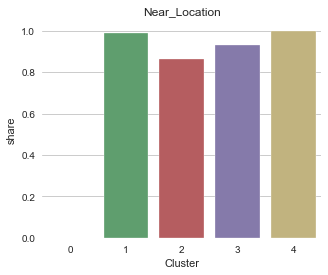

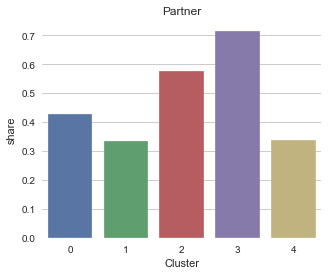

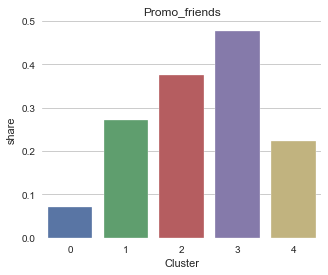

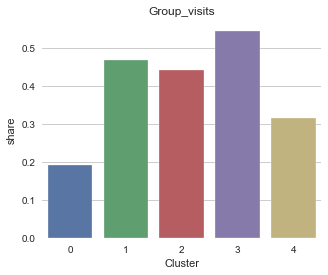

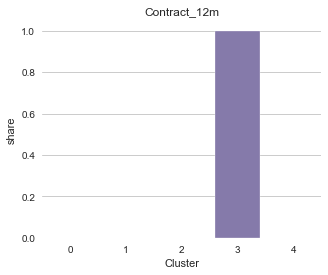

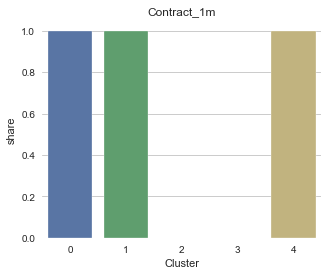

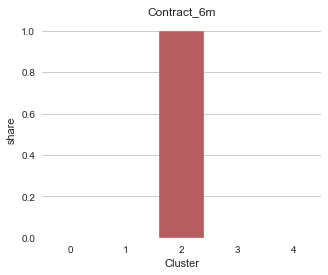

In [34]:
for col in data[['Near_Location', 'Partner', 'Promo_friends', 'Group_visits',
                 'Contract_12m', 'Contract_1m', 'Contract_6m']]:
    sns.set_style("whitegrid")
    fig, axs = plt.subplots(figsize=(5, 4))
    sns.barplot(data=mean_clusters, x=mean_clusters['Cluster'], y=mean_clusters[col])
    plt.title(col)
    plt.ylabel('share')
    plt.show()

The plots give good visualization for differences in clusters. Summary analysis is provided below.

### Numerical values plots for clusters

Plotting kdeplots for the clusters (numerical features):

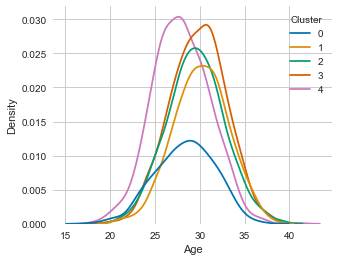

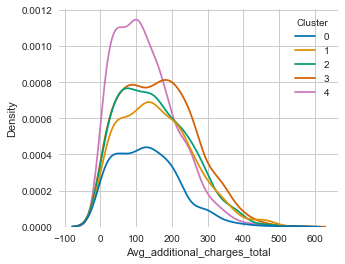

C:\Users\agord\anaconda3\lib\site-packages\seaborn\distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
C:\Users\agord\anaconda3\lib\site-packages\seaborn\distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


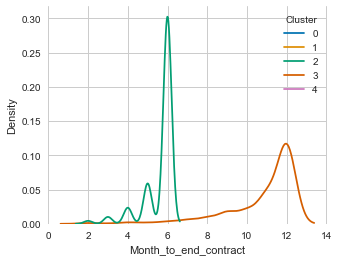

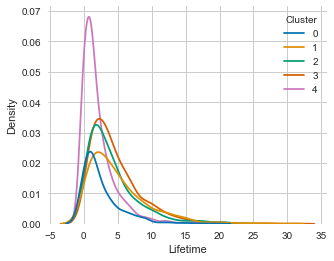

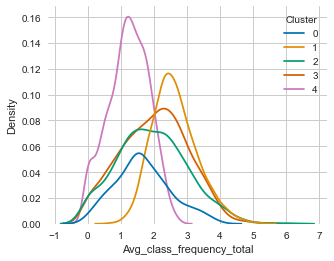

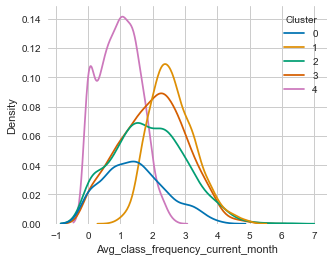

In [35]:
for col in data[['Age', 'Avg_additional_charges_total', 'Month_to_end_contract','Lifetime',
                'Avg_class_frequency_total', 'Avg_class_frequency_current_month']]:
    sns.set_style("whitegrid")
    fig, axs = plt.subplots(figsize=(5, 4))
    sns.kdeplot(data=data, x=col, hue='Cluster', palette='colorblind')
    plt.show()

The plots show that clusters 4 and 0 stand out from the whole dataset and require more careful study.

### Clusters analysis

Calculating churn rate for clusters:

In [36]:
clusters=data.groupby('Cluster')['gender'].count().reset_index()
clusters.rename(columns={'gender': 'Clients'}, inplace=True)
clusters['Share,%']=round(clusters['Clients']/len(data)*100,2)
clusters['Churn']=data.groupby('Cluster')['Churn'].sum()
clusters['Churn_rate,%']=round((clusters['Churn']/clusters['Clients']*100),2)
clusters

,Cluster,Clients,"Share,%",Churn,"Churn_rate,%"
0,0,432,10.80,225,52.08
1,1,753,18.82,80,10.62
2,2,833,20.82,104,12.48
3,3,960,24.00,23,2.40
4,4,1022,25.55,629,61.55


**Cluster analysis summary:**
Clusters 4 and 0 has the highest churn rates. Retention strategy should be focused on clients from these clusters. Below I provide features overview for these 2 clusters.

Cluster 4 has the highest churn rate of 62% (vs 26% for the whole dataset). This cluster has the following feature values:
- All clients live near gym
- 34% of clients are employees of partner companies (vs 49% in the whole dataset)
- 22% of clients signed up through a "bring a friend" offer (vs 31% in the whole dataset)
- 32% of clients taking part in group sessions (vs 41% in the whole dataset)
- All clients has contract period of 1 month (vs 55% in the whole dataset)
- The average age of client is 28 years (vs 29 years in the whole dataset)
- The average of the total amount of money spent on other gym services is 125 currency units (vs 145 currency units in the whole dataset)
- On average the client first came to the gym 2.1 month ago (vs 3.7 months in the whole dataset)
- The average frequency of visits per week (over the customer's lifetime) is almost 1.2 (vs 1.9 in the whole dataset)
- Contract expires in 1 month

Cluster 0 has the highest churn rate of 53% (vs 26% for the whole dataset). This cluster has the following feature values:
- None of the clients live near gym
- 43% of clients are employees of partner companies (vs 49% in the whole dataset)
- 7% of clients signed up through a "bring a friend" offer (vs 31% in the whole dataset)
- 19% of clients taking part in group sessions (vs 41% in the whole dataset)
- All clients has contract period of 1 month (vs 55% in the whole dataset)
- The average age of client is 28 years (vs 29 years in the whole dataset)
- The average of the total amount of money spent on other gym services is 130 currency units (vs 145 currency units in the whole dataset)
- On average the client first came to the gym 2.6 month ago (vs 3.7 months in the whole dataset)
- The average frequency of visits per week (over the customer's lifetime) is almost 1.7 (vs 1.9 in the whole dataset)
- Contract expires in 1 month

## Conclusions and recommendations on working with customers

The initial dataset consisted of 4000 entries on 13 features and churn data.

**Highlights on dataset:**
- Overall churn rate 26%
- Short term contracts constitutes 55% in total
- Clients involved in loyalty programs (employees of partner companies, clients signed up through a 'bring a friend') offer demonstrate lower churn rates)
- The  average age of client is 29 years
- The average of the total amount of money spent on other gym services (cafe, athletic goods, cosmetics, massages and etc.) is 145 currency units
- On average the client first came to the gym about 3.7 months ago
- The average frequency of visits per week (over the customer's lifetime) is almost 1.9
- 41% of clients participate in group sessions

I have restructured data and rain the model on the trained set with two methods:
- logistic regression
- random forest

I recommend using **logistic regression model** to predict client's churn.

I have analyzed separately data for leaving and staying clients and trained the clustering model with the K-means algorithm to predict 5 customer clusters and on the basis of my analysis I have the following recommendations regarding clients retention strategy.

**Recommendations:**
1) Increase share of long contracts (for 6 or 12 months) - clients with long contracts are less likely to churn. 

2) Attract more clients, that live near the gym - they are less likely to churn.

3) Clients, that need more attention: 
- age about 28 years
- average frequency of visits per week about 1.5
- no visits during last month
- not involved in loyalty programs (partner companies/'bring a friend' offer)
- contracted for 1 month
- total spending on other services is less 150 currency units

What can we offer them to make them stay? I suggest to obtain feedback from them via questionnaire to find out what do they need.

4) Clients with contract that expires in the next month also need attention from sales team. I would suggest:
- get a feedback from them (what they like, what they don't like, are they plan to prolong a contract)
- consider options for discount to make them stay, if they are going to leave
- propose them some additional services free of charge, if they sign contract for another 6 or 12 months